### Module import

In [6]:
!pip install pytorch-gradcam

     |████████████████████████████████| 51.6MB 356kB/s eta 0:00:01     |███████████████████▋            | 31.5MB 988kB/s eta 0:00:21


In [19]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cpu'

### Load image

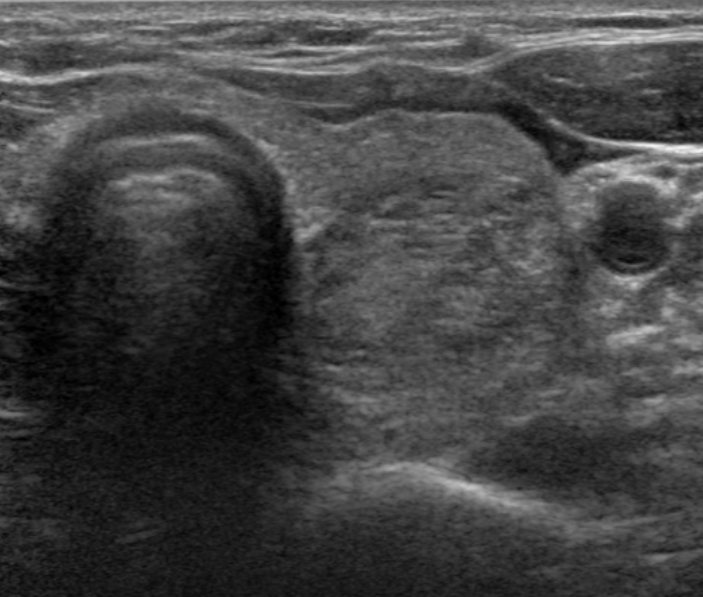

In [59]:
img_dir = '/Volumes/hack014/A-DEEP-CONVOLUTIONAL-NEURAL-NETWORK-FOR-IDENTIFYING-THYROID-CANCER/model/thyroidemb/mixed/utsw_test/benign'
# img_name = '4736_17_trv_0008_T4.tif'
# img_name = '4785_25_0010_T4.tif'
# img_name = '4852_33_trv_11_T5.tif'
# img_name = '4942_18_yrv_0016_T4.tif'

# BENIGN:
# img_name = '4881_30_trv_0014_T3.tif'
img_name = '4221_29_trv_trv_0042_T3.tif'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path).convert('RGB')
pil_img

### preprocess image

In [60]:
torch_img = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

### Load torchvision models and make configs

In [30]:
import torch.nn as nn
resnet = models.resnet50(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)

model_file = os.path.abspath('/Volumes/hack014/A-DEEP-CONVOLUTIONAL-NEURAL-NETWORK-FOR-IDENTIFYING-THYROID-CANCER/model/thyroidemb/resnet-mixed2/model.pt')
resnet.load_state_dict(torch.load(model_file,map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [31]:
configs = [
    dict(model_type='resnet', arch=resnet, layer_name='layer4'),
]

In [32]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [61]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

/Users/mike/intelpython2/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### Show results 

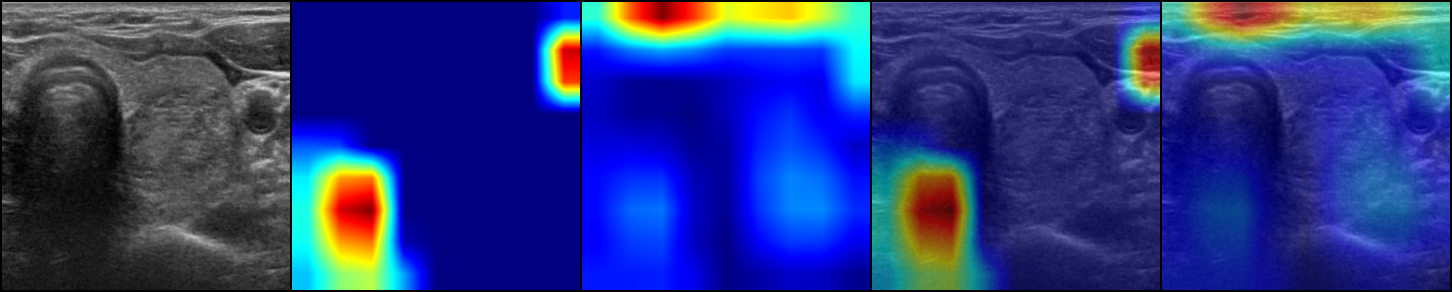

In [62]:
transforms.ToPILImage()(grid_image)